In [27]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns

In [28]:
all_play_returns = []
all_test_returns = []

results_root = Path("..")/ "results"

min_num_episodes = 100000000


for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)


    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None

    seed = params["seed"]

    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        all_play_returns.append([agent, offset, radius, seed, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = np.mean(test_returns, axis=1)
        all_test_returns.append([agent, offset, radius, seed, mix_ratio] + list(test_returns))



In [29]:
cat_cols = ["agent", "offset", "radius", "seed",  "mix_ratio"]
cols = cat_cols + list(range(100))
all_test_returns = pd.DataFrame(data= all_test_returns, columns = cols )
all_test_returns = all_test_returns.infer_objects()
all_test_returns = all_test_returns.set_index(cat_cols)
all_test_returns = all_test_returns.cumsum(axis=1)
all_test_returns = all_test_returns.reset_index()


for i in range(len(all_play_returns)):
    all_play_returns[i] = all_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
all_play_returns = pd.DataFrame(data= all_play_returns, columns = cols )
all_play_returns= all_play_returns.infer_objects()
all_play_returns= all_play_returns.set_index(cat_cols)
all_play_returns= all_play_returns.cumsum(axis=1)
all_play_returns= all_play_returns.reset_index()


# condition on mix ratio
#all_test_returns = all_test_returns[all_test_returns['mix_ratio'] == 1/4]
#all_play_returns = all_play_returns[all_play_returns['mix_ratio'] == 1/4]


In [30]:
all_test_returns

agent  offset  radius  seed  mix_ratio    0    1    2    3    4  \
0   uniform_zpd    -2.0     0.0  8479     0.0625  0.5  0.0  0.0  0.5  0.4   
1   uniform_zpd    -2.0    16.0  8479     0.0625  0.0  0.0  0.0  0.0  0.6   
2   uniform_zpd    -2.0     2.0  8479     0.0625  0.4  0.4  0.0  0.0  0.3   
3   uniform_zpd    -2.0     4.0  8479     0.0625  0.0  0.1  0.0  0.4  0.2   
4   uniform_zpd     0.0     0.0  8479     0.0625  1.2  0.6  0.5  0.2  0.0   
..          ...     ...     ...   ...        ...  ...  ...  ...  ...  ...   
61  uniform_zpd     2.0     4.0  8479     0.2500  0.6  0.0  0.4  0.0  0.2   
62  uniform_zpd     2.0    16.0  8479     0.2500  0.4  0.0  0.6  0.5  0.0   
63  uniform_zpd    -2.0     4.0  8479     0.2500  0.0  0.0  0.0  0.4  0.2   
64  uniform_zpd    -2.0    16.0  8479     0.2500  0.0  0.0  0.3  1.0  0.0   
65  uniform_zpd    -2.0     2.0  8479     0.2500  0.5  0.5  0.5  0.0  0.0   

    ...    90    91    92    93    94    95    96    97    98    99  
0   ...  21.7  27.2  27.6  19.8  15.3  30.7  28.3  25.4  28.5  17.8  
1   ...  19.1  18.1  12.7  25.2  27.9   9.5   8.4  20.6  10.8  34.0  
2   ...  18.0  19.7  13.7  16.8  13.0  13.4  18.0  25.7  17.4  42.1  
3   ...  23.4  23.0  19.1  23.9  20.2  19.6  17.5  28.0  27.4  38.8  
4   ...  19.1  19.6  16.5  13.7   6.8  26.6  28.9  12.1  30.7  12.9  
..  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
61  ...  33.3  19.0  18.7  24.4  17.5  15.0  18.6  20.6  26.1  12.8  
62  ...   8.0   9.6  14.3  31.0  26.1  12.8  19.2  20.8  17.6   6.0  
63  ...  18.5  17.9  28.0  17.6  19.2  25.0  27.5  17.5  12.3  32.3  
64  ...   7.1  27.3  17.1  18.5  18.8  12.5  17.7  26.6  25.8  31.8  
65  ...  25.4  35.5  23.2  17.4  12.6  45.2  17.2  17.6  20.6  17.1  

[66 rows x 105 columns]

In [31]:



all_test_returns.loc[   all_test_returns[99].argmax()]

agent        uniform_zpd
offset                -2
radius                 2
seed                8479
mix_ratio         0.0625
                ...     
95                  13.4
96                    18
97                  25.7
98                  17.4
99                  42.1
Name: 2, Length: 105, dtype: object

In [32]:
all_test_returns_melt = pd.melt(all_test_returns, id_vars= cat_cols
, var_name = "Step",value_name= "Reward", value_vars=list(range(0, 100)))

all_test_returns_melt['Config'] = all_test_returns_melt["agent"].str.cat(all_test_returns_melt['offset'].astype(str), sep = ": ").str.cat(all_test_returns_melt['radius'].astype(str), sep = ": ").str.cat(all_test_returns_melt['mix_ratio'].astype(str), sep = ": ")    



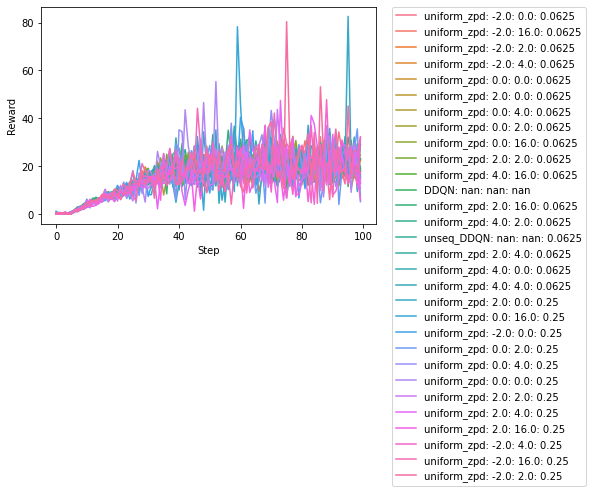

In [33]:


plot = sns.lineplot(x="Step", y= "Reward", hue="Config",ci = None,  data=all_test_returns_melt)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures/cumulative_test_mix.pdf", bbox_inches = "tight")

In [34]:
all_play_returns_melt = pd.melt(all_play_returns, id_vars= cat_cols
, var_name = "Step",value_name= "Reward", value_vars=list(range(0, min_num_episodes)))

all_play_returns_melt['Config'] = all_play_returns_melt["agent"].str.cat(all_play_returns_melt['offset'].astype(str), sep = ": ").str.cat(all_play_returns_melt['radius'].astype(str), sep = ": ").str.cat(all_play_returns_melt['mix_ratio'].astype(str), sep = ": ")



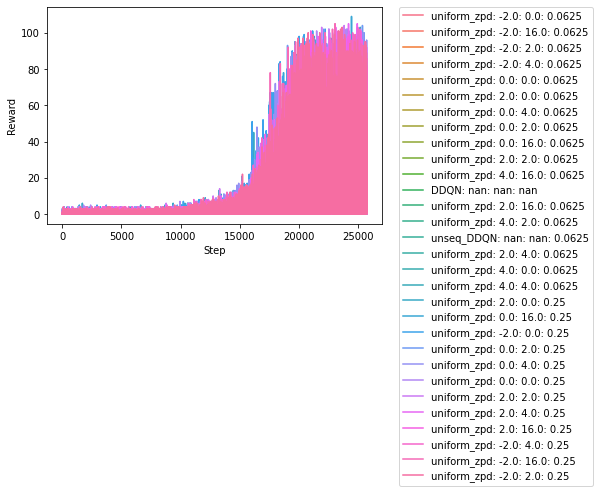

In [35]:
plot = sns.lineplot(x="Step", y= "Reward", hue="Config",ci = None,  data=all_play_returns_melt)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures/cumulative_play.pdf", bbox_inches = "tight")